In [ ]:
# go wide screen

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
def pp(s):
    print(s)
    return s + "\n"

# Datamodel for the flow network

In [ ]:
# Add current working directory to pythonpath
import sys
sys.path.append("/Users/mxhf/ownCloudRZG/work/MPE/pfs/ETS/real_test")

# Next two lines forc outomatic reload of loaded module. Convenient if
# one is still fiddeling with them.
%load_ext autoreload
%autoreload 2

import pfs_netflow.datamodel as dm

# Read the catalogs, compute visibility ... 

In [5]:
#BLOCKLENGTH = 300. # block exposure time in s, to simulate three consequtive exposures
BLOCKLENGTH = 900. # block exposure time in s

In [6]:
from astropy.io import ascii
import numpy as np
test = ascii.read("pfs_target_list/pfs_preliminary_target_galaxy.dat")

cRA  = np.median( test['R'] )  
cDEC =  np.median( test['Dec'] ) 
RAmin,RAmax   = np.min( test['R'] ), np.max( test['Dec'] )
DECmin,DECmax = np.min( test['R'] ), np.max( test['Dec'] )

print(cRA)
print(cDEC)

150.69672
2.79469


In [7]:
# Define target lists.
fscience_targets = "pfs_target_list/pfs_preliminary_target_galaxy.dat"

# Kohei did no provide a list of cal stars or sky positions
# we will make some up

#fcal_stars       = "../../ETS/pfs_target_list/pfs_preliminary_target_cosmology_fcstars.dat"
#fsky_pos         = "../../ETS/pfs_target_list/pfs_preliminary_target_cosmology_sky.dat"

# Load target lists.
from astropy.io import ascii
science_targets = ascii.read(fscience_targets)

# translate column names
science_targets['ID'].name = 'ID'
science_targets['R'].name = 'RA'
science_targets['Dec'].name = 'DEC'
science_targets['Exposure'].name = 'EXP_TIME'
science_targets['Priority'].name = 'Priority'
    
#cal_stars = ascii.read(fcal_stars)

#sky_pos = ascii.read(fsky_pos)

In [8]:
# make up calibration stars and sky positions
# carful IDs of all objects must be unique!!!
from astropy.table import Table, Column


cRA  = np.median( science_targets['RA'] )  
cDEC =  np.median( science_targets['DEC'] ) 
RAmin,RAmax   = np.min( science_targets['RA'] ), np.max( science_targets['RA'] )
DECmin,DECmax = np.min( science_targets['DEC'] ), np.max( science_targets['DEC'] )


cal_stars = Table()
sky_pos   = Table()

NSTAR = 250
NSKY  = 2500

rr_star = np.random.uniform(size=NSTAR, low=RAmin, high=RAmax)
dd_star = np.random.uniform(size=NSTAR, low=DECmin, high=DECmax)
tt_star = np.ones_like(rr_star) * 900.
pp_star = np.ones_like(rr_star) * 1

cal_stars['ID']        = Column(["c{:06d}".format(i) for i in range(NSTAR)], unit='', description='')
cal_stars['RA']        = Column(rr_star, unit='deg', description='RA')
cal_stars['DEC']       = Column(dd_star, unit='deg', description='DEC')
cal_stars['EXP_TIME']  = Column(tt_star, unit='s', description='Exposure time')
cal_stars['Priority']  = Column(pp_star, unit='', description='Priority', dtype='int')


rr_sky = np.random.uniform(size=NSKY, low=RAmin, high=RAmax)
dd_sky = np.random.uniform(size=NSKY, low=DECmin, high=DECmax)
tt_sky = np.ones_like(rr_sky) * 900.
pp_sky = np.ones_like(rr_sky) * 1

sky_pos['ID']        = Column(["s{:06d}".format(i) for i in range(NSKY)], unit='', description='')
sky_pos['RA']        = Column(rr_sky, unit='deg', description='RA')
sky_pos['DEC']       = Column(dd_sky, unit='deg', description='DEC')
sky_pos['EXP_TIME']  = Column(tt_sky, unit='s', description='Exposure time')
sky_pos['Priority']  = Column(pp_sky, unit='', description='Priority', dtype='int')



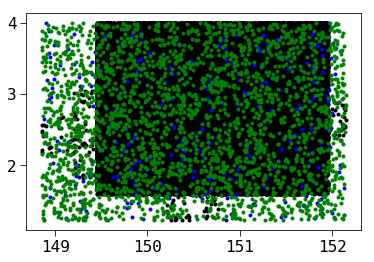

In [9]:
plt.plot(science_targets['RA'], science_targets['DEC'] , '.')
plt.plot(cal_stars['RA'], cal_stars['DEC'] , '.')
plt.plot(sky_pos['RA'], sky_pos['DEC'] , '.')

In [10]:
# Convert data to lists for ETS.
import numpy as np
from numpy import hstack
from numpy import cos, deg2rad, sqrt
from numpy import unique, array


ID         = hstack([science_targets['ID'],cal_stars['ID'],sky_pos['ID']])
ra         = hstack([science_targets['RA'],cal_stars['RA'],sky_pos['RA']])
dec        = hstack([science_targets['DEC'],cal_stars['DEC'],sky_pos['DEC']])
exp_times  = hstack([science_targets['EXP_TIME'],cal_stars['EXP_TIME'],sky_pos['EXP_TIME']])
priorities = hstack([science_targets['Priority'],cal_stars['Priority'],sky_pos['Priority']])

# make up target classes from target type and priority
types = ["sci"]*len(science_targets) + ["cal"]*len(cal_stars) + ["sky"]*len(sky_pos)
class_dict = {}
for id,t,p in zip(ID, types, priorities):
    class_dict[id] = '{}_P{:02d}'.format(t, p)
    
# limit targets to a smaller field of view
#pointing_RA, pointing_DEC = 33.7025, -3.8455 # Cosmology
#pointing_RA, pointing_DEC = 227.304747, 67.24684 #UMi
pointing_RA, pointing_DEC = 150.69672, 2.79469 # GE

# Apply radial cut
DRMAX_SQ = .75**2
DRMAX_SQ = .02**2
DRMAX_SQ = (2700./3600.)**2.
#DRMAX_SQ = .5**2

dra = (ra - pointing_RA)*cos(deg2rad(dec))
ddec = dec - pointing_DEC
ii = (dra**2. + ddec **2.) <= DRMAX_SQ

ID = ID[ii].tolist()
ra = ra[ii].tolist()
dec = dec[ii].tolist()
exp_times = exp_times[ii].tolist()
priorities = priorities[ii].tolist()
types = np.array(types)[ii].tolist()

# could have used types here, but later need to reidentify types via the ID
# since ETC does nto maintain the order.
c = np.array([ class_dict[t][:3] for t in ID ])
ii_sci = c == 'sci'
ii_cal = c == 'cal'
ii_sky = c == 'sky'

#ii_sci = np.array(types) == 'sci'
#ii_cal = np.array(types) == 'cal'
#ii_sky = np.array(types) == 'sky'

print( "{} science targets, {} calibration targets, and {} sky positions survive radial cut.".format(sum(ii_sci),sum(ii_cal),sum(ii_sky)))

35908 science targets, 44 calibration targets, and 466 sky positions survive radial cut.


In [11]:
# assign random priorities between 1 and 3 for the  science targets
if False:
    # Kohei's catalog already does come with priorities
    from numpy import random
    from numpy import array

    random.seed(42)

    N =  sum(ii_sci) 

    newpri = array( random.uniform(1.,4., size=N) , dtype=int)
    priorities = np.array(priorities)

    priorities[ii_sci] = newpri
    priorities = priorities.tolist()

In [12]:
# compute number of required visists from exposure times
# and block length
nreqv_dict = {}
for id,t,nrv in zip(ID, types, array(exp_times)/BLOCKLENGTH):
    nreqv_dict[id] = int(nrv)
    
print "Required revisits", unique( [v for v in nreqv_dict.itervalues()] )

Required revisits [ 1  8 12 20 24 64]


In [13]:
# RANDOMISE NUMBER OF REQUIRED VISISTS
RANDOMIZENREQ = False
if RANDOMIZENREQ:
    NVISITS = 10
    nv = np.floor( random.uniform(NVISITS+1, size=len(ID)) ) 

    # compute number of required visists from exposure times
    # and block length
    nreqv_dict = {}
    for id,t,nrv in zip(ID, types, nv):
        nreqv_dict[id] = int(nrv)

    print "Required revisits", unique( [v for v in nreqv_dict.itervalues()] )

In [14]:
#sys.path.append("/Users/mxhf/ownCloudRZG/work/MPE/pfs/src/ets_fiber_assigner")

import pyETS
import pycconv

# Temporary, very crude method to convert Ra/Dec pairs to x/y coordinates
# on the focal plane. To be replaced by the official functionality once
# available.
# All input angles are expected in degrees.
def radec2pos(ras, decs, raTel=None, decTel=None, posang=0.,
              time="2016-04-03T08:00:00Z"):
    if raTel is None:
        raTel = np.average(ras)
    if decTel is None:
        decTel = np.average(decs)
    return pycconv.cconv(ras,decs,raTel,decTel,posang+90.,time)

# get a data structure containing the idealized cobras
ets_cobras = pyETS.getAllCobras()

# Parse a target file and return the quantities of interest
ets_target_pos = radec2pos(ra,dec)

# get a list of targets, and a list of Cobras that can observe them
# keys contain object index
# values contain indices of cobras that can observe that object.
visibility_map = pyETS.getVis(ets_target_pos, ets_cobras)

In [15]:
#Interface to the new ETS, convert cobras, visibilities and targets to old style format
from collections import OrderedDict

# obtain cobra centers in old ETS dictionary style
cobras = OrderedDict()
for i,c in enumerate(ets_cobras):
        x,y = np.real( ets_cobras[i][0] ), np.imag( ets_cobras[i][0] )
        cobras["{:d}".format(i)] = [x,y]

# obtain target positions in old ETS dictionary style
targets = OrderedDict()
for i,c in enumerate(ets_target_pos):
        x,y = np.real(c),np.imag(c)
        targets[ID[i]] = [float(x),float(y)]

# obtain visibilities in old ETS dictionary style
visibilities = OrderedDict()   
for v in visibility_map:
    t = ID[v]
    cc = ["{:d}".format(c) for c in visibility_map[v]]
    visibilities[t] = cc
    

In [16]:
if False:
    f = plt.figure(figsize=[10,10])
    cxx = [c[0] for cid, c in cobras.iteritems()]
    cyy = [c[1] for cid, c in cobras.iteritems()]
    txx = [t[0] for tid, t in targets.iteritems()]
    tyy = [t[1] for tid, t in targets.iteritems()]

    if True:
        for tid,cc in visibilities.iteritems():
            tx,ty = targets[tid]
            for c in cc:
                cx,cy = cobras[c]
                #print c
                #plt.text(cx,cy,"{}".format(c) )
                plt.plot([cx,tx],[cy,ty],'k-')


    plt.plot(cxx,cyy,'.')
    plt.plot(txx,tyy,'.')

    plt.axis('equal')
    plt.xlim([-20,20])
    plt.ylim([-20,20])

In [17]:
# perform target assignment using the "draining" algorithm, and return the list
# of assigned targets and which cobras were used to observe them.
#res = pyETS.getObs(ets_target_pos,exp_times,priorities,ets_cobras,"draining_closest")

In [18]:
# Assign targetclass labels according to target type and priority
from numpy import unique

# Build dict that holds class descriptor string for each target.
# This is needed later because ETS does not preserve the order.
tclasses =   np.array( [class_dict[t] for t in targets] )
print(unique(tclasses))

# Build dict that holds required number of visits each target.
nreqvisits = [nreqv_dict[t] for t in targets]

['cal_P01' 'sci_P01' 'sci_P02' 'sci_P03' 'sci_P04' 'sci_P05' 'sci_P06'
 'sky_P01']


Text(0,0.5,'y [mm]')

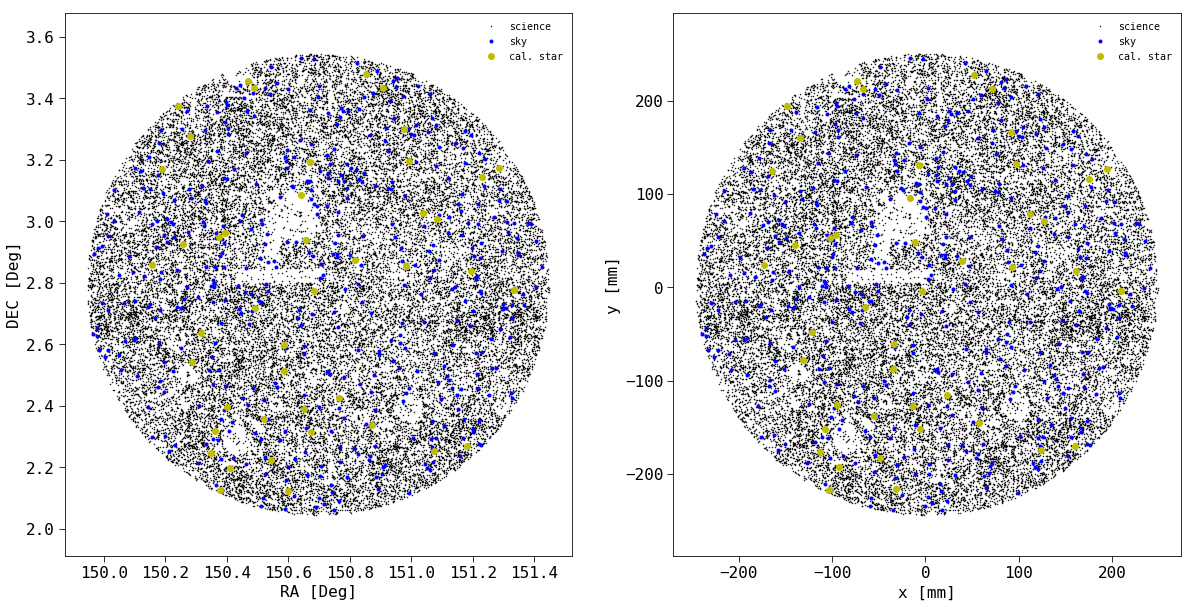

In [19]:
# plot targets on sky
f = plt.figure(figsize=[20,10])
plt.subplot(121)
plt.plot(np.array(ra)[ii_sci],np.array(dec)[ii_sci],'.', ms=1, label='science')
plt.plot(np.array(ra)[ii_sky],np.array(dec)[ii_sky],'b.' , label='sky')
plt.plot(np.array(ra)[ii_cal],np.array(dec)[ii_cal],'yo' , label='cal. star')
plt.axis('equal')
l = plt.legend()
l.draw_frame(False)
plt.xlabel("RA [Deg]")
plt.ylabel("DEC [Deg]")

plt.subplot(122)

txx = np.array( [t[0] for tid, t in targets.iteritems()] )
tyy = np.array( [t[1] for tid, t in targets.iteritems()] )


#for tc in unique(tclasses):

_ii_sci = map( lambda x : x.startswith('sci') , tclasses )
_ii_sky = map( lambda x : x.startswith('sky') , tclasses )
_ii_cal = map( lambda x : x.startswith('cal') , tclasses )
plt.plot(txx[_ii_sci],tyy[_ii_sci],'.', ms=1, label='science')
plt.plot(txx[_ii_sky],tyy[_ii_sky],'b.' , label='sky')
plt.plot(txx[_ii_cal],tyy[_ii_cal],'yo' , label='cal. star')

#plt.plot(txx[ii_sky],tyy[ii_sky],'b.' , label='sky')
#plt.plot(txx[ii_cal],tyy[ii_cal],'yo' , label='cal. star')


plt.axis('equal')
l = plt.legend()
l.draw_frame(False)
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")

# Collisions

In [28]:
ENABLE_COLLISION_AVOIDANCE = False

if ENABLE_COLLISION_AVOIDANCE:
    # find collision pairs
    from scipy.spatial.distance import cdist
    fiber_collision_radius = 1.


    f = plt.figure(figsize=[5,5])
    plt.subplot()
    txx = np.array( [t[0] for tid, t in targets.iteritems()] )
    tyy = np.array( [t[1] for tid, t in targets.iteritems()] )

    _ii_sci = map( lambda x : x.startswith('sci') , tclasses )
    _ii_sky = map( lambda x : x.startswith('sky') , tclasses )
    _ii_cal = map( lambda x : x.startswith('cal') , tclasses )


    plt.plot(txx[_ii_sci],tyy[_ii_sci],'.', ms=1, label='science')
    plt.plot(txx[_ii_sky],tyy[_ii_sky],'b.' , label='sky')
    plt.plot(txx[_ii_cal],tyy[_ii_cal],'yo' , label='cal. star')


    N = len(ID)
    points = zip(txx,tyy)
    Y = cdist( points[:N], points[:N] )

    # any target separation that is smaller than 2 x the collision radius will be flagged a s collision
    cc = Y <= (fiber_collision_radius*2.) 
    ncoll = int( (np.sum(cc.flatten()) - N)/2. )

    print ("Found  {:d} collision pairs.".format( ncoll  ))

    # identify collision pairs
    collision_pairs = []
    # array of indices
    ii = np.arange(N)
    for i in range(cc.shape[0]):
        x1,y1 =  txx[i], tyy[i]
        # only iterate over the indeces that are colliding and the upper diagonal in the collision matrix
        jj = ii[ cc[i,:] * ii > i ] 
        for j in jj: 
            if cc[i,j]:
                x2,y2 =  txx[j], tyy[j]
                collision_pairs.append([(ID[i],x1,y1),(ID[j],x2,y2)])



    for cp in collision_pairs:
        plt.plot([cp[0][1],cp[1][1]],[cp[0][2],cp[1][2]],'r-')
        #plt.plot(txx[ii_cal],tyy[ii_cal],'yo' , label='cal. star')

    print len(collision_pairs)

    plt.axis('equal')
    l = plt.legend()
    l.draw_frame(False)
    plt.xlabel("x [mm]")
    plt.ylabel("y [mm]")
    plt.xlim([-15,15])

# Invert visibilities

In [20]:
# Compute a few statistics:
# Number of rachable targets by type and
# number of cobras that can observe any target.
def invert_vis(visibilities):
    """
    Invert visibility map, i.e. for each cobra list the observable targets
    """
    ivisibilities = {}

    cnt = 0
    for v in visibilities:
        t = v
        cc = visibilities[v]

        for c in cc:
            if ivisibilities.has_key(c):
                ivisibilities[c].append(v)
            else:
                ivisibilities[c] = [v]

    return ivisibilities

ivisibilities = invert_vis(visibilities)           

In [21]:
nsci_observable = 0
ncal_observable = 0
nsky_observable = 0

for tid,v in visibilities.iteritems():
    if len(v) > 0:
        if class_dict[tid][:3] == 'cal':
            ncal_observable += 1
        elif class_dict[tid][:3] == 'sky':
            nsky_observable += 1
        elif class_dict[tid][:3] == 'sci':
            nsci_observable += 1
        #break
            
            
print("{} targets positions in total.".format(sum(ii_sci) ))
print("{} cal. targets in total.".format(sum(ii_cal) ))
print("{} sky positions in total.".format(sum(ii_sky) ))
print("{} cobras have at least one target in reach.".format(len(ivisibilities)))
print("{} science targets\n{} calibration targets, \
and \n{} sky positions are in reach of at least one cobra.".format(nsci_observable, ncal_observable, nsky_observable))  

35908 targets positions in total.
44 cal. targets in total.
466 sky positions in total.
2388 cobras have at least one target in reach.
22606 science targets
28 calibration targets, and 
302 sky positions are in reach of at least one cobra.


# run the ETS solver

In [22]:
def fil(xx,bb):
    """
    Takes a list of objects and a boolean list of same length.
    Retruns a list with all thos object for which the boolean
    input list had a True.
    """
    new = []
    for x,b in zip(xx,bb):
        if b: new.append(x)
    return new

In [1]:
import numpy as np
import time
    
ALGORITHM = "new"
ALGORITHM = "draining"
ALGORITHM = "naive"
ALGORITHM = "draining_closest"

ALL_ALGORITHM = ["new", "draining", "naive", "draining_closest"]

for ALGORITHM in ALL_ALGORITHM:
    print("ALGORITHM {}".format(ALGORITHM))
    NVISISTS = 10
    ii = np.full_like(ID, True, dtype=bool)

    # set priorities 
    priorities2 = np.array(priorities)
    priorities2[ii_sci] = 5
    priorities2[~ii_sci] = 1
    priorities2 = priorities2.tolist()

    with open("ets_results_{}.txt".format(ALGORITHM), 'w') as f:
        s = "# algorithm: {}\n".format(ALGORITHM)
        s += "# total number of vistis: {}\n".format(NVISISTS)

        s += "# total number of observable science targets: {}\n".format(nsci_observable)
        s += "# total number of observable cal. targets: {}\n".format(ncal_observable)
        s += "# total number of observable sky positions: {}\n".format(nsky_observable)
        s += "{:3s} {:5s} {:5s} {:5s} {:5s}\n".format("V", "nsci", "ncal", "nsky", "nsci_total")
        f.write(s)

        for v in range(NVISISTS):
            s= ""

            print("Visit {}".format(v))
            print(" Number of remaining targets to observe: {}".format(sum(ii)))

            #print(" Number of remaining cal. targets to observe: {}".format( sum( np.array(types)[ii] == "cal" ) ))
            #print(" Number of remaining sky targets to observe: {}".format( sum( np.array(types)[ii] == "sky" ) ))

            start_time = time.time()
            # perform target assignment using the "draining" algorithm, and return the list
            # of assigned targets and which cobras were used to observe them.
            #res = pyETS.getObs(fil(ets_target_pos,ii),fil(exp_times,ii),fil(priorities,ii),ets_cobras,"draining_closest")
            res = pyETS.getObs(ets_target_pos,exp_times,priorities2,ets_cobras,ALGORITHM)
            time_to_build = time.time() - start_time
            pp(" Time to solve: {:.4e} s".format(time_to_build))



            # figure which out of all potential science targets have been observed
            # and mark them as observed
            for r in res:
                if types[r] == 'sci':
                    priorities2[r] = 15
                    ii[r] = False

            # compute some statistics
            nsci_observed = sum(np.array(types)[ res.keys() ] == 'sci')
            ncal_observed = sum(np.array(types)[ res.keys() ] == 'cal')
            nsky_observed = sum(np.array(types)[ res.keys() ] == 'sky')
            print(" Observed {} science targets, {} calibration targets and {} sky positions"\
                  .format(nsci_observed, ncal_observed, nsky_observed))
            N = len( res.items() )
            #print(" Observed {} targets.".format(N))
            nsci_observed_total = sum(ii_sci * ~ii)
            print(" Observed {} science targets in total.".format(nsci_observed_total))
            print("")

            s += "{:3d} {:5d} {:5d} {:5d} {:5d}\n".format(v, nsci_observed, ncal_observed, nsky_observed, nsci_observed_total)
            f.write(s)

#np.any( np.array(types)[ res.keys() ] == 'cal' )

ALGORITHM new


NameError: name 'ID' is not defined

In [ ]:
# Plot unobserved targets
from numpy import array
from matplotlib import pyplot as plt
% matplotlib inline
f = plt.figure(figsize=[5,5])

#plt.plot(fil(ra,~ii), fil(dec,~ii), '.', color='k')
plt.plot(fil(ra,ii), fil(dec,ii), '.', color='r', alpha=0.1)

plt.ylabel('dec [Deg]')
plt.xlabel('ra [Deg]')
#plt.axis("equal")

#plt.xlim([33.25,34.74])
#plt.ylim([-5.25,-3.75])

# Execute netflow

In [24]:
# Define the cost function
from numpy import inf

cost_dict = {}
# For each target class we define the cost of non-observation
# and non-completion as a two-tuple. The cost of non-completion 
# is typically larger as partial completion of objects should be avoided.
cost_dict['sci_P01'] = (10000000000.,1e15)
cost_dict['sci_P02'] = (1000000000.,1e15)
cost_dict['sci_P03'] = (100000000.,1e15)
cost_dict['sci_P04'] = (10000000.,1e15)
cost_dict['sci_P05'] = (1000000.,1e15)
cost_dict['sci_P06'] = (100000.,1e15)
cost_dict['sci_P07'] = (10000.,1e15)
cost_dict['sci_P08'] = (1000.,1e15)
cost_dict['sci_P09'] = (100.,1e15)
cost_dict['sci_P10'] = (10.,1e15)


# For the calibration objects we only define the cost
# of non-observation as calibration targets only *need* to be visited once.
# Note: The can of course be visited many times. But
# for the calibration objects the real constraint is to have 
# at least N out of M observed in each exposure.
# There is no requirement to revisit a specific calibration target.
cost_dict['cal_P01'] = 1e12
cost_dict['sky_P01'] = 1e12

# Here we add higher cost to later visits. Ther should be one entry per visit.
cost_dict['visits'] = [i*10. for i in np.arange(64)]

# Here we discourage large cobra moves. The example here is a simple
# linear function cost = A * move_distance 
# where the parameter A controls how quickly the cost increases as funciton of distance.
#A = 250.
A = 0.
cost_dict['cobra_move'] = lambda d : d*A  


# Here we define how at least many objects out of each class we want observed.
supply_dict = {}
# By setting science object to inf, we say we want them all.
supply_dict['sci_P01'] = inf
supply_dict['sci_P02'] = inf
supply_dict['sci_P03'] = inf
supply_dict['sci_P04'] = inf
supply_dict['sci_P05'] = inf
supply_dict['sci_P06'] = inf
supply_dict['sci_P07'] = inf
supply_dict['sci_P08'] = inf
supply_dict['sci_P09'] = inf
supply_dict['sci_P10'] = inf

# need one calibration star per exposure
supply_dict['cal_P01'] = 16 # inf = try to get as amny as  possible
# need one sky positions per exposure
supply_dict['sky_P01'] = 322 # inf = try to get as amny as  possible


# need one calibration star per exposure
supply_dict['cal_P01'] = 1# 12
# need one sky positions per exposure
supply_dict['sky_P01'] = 1# 329

In [25]:
# Build the survey plan graph.

from numpy import inf
from pfs_netflow.survey_plan import buildSurveyPlan
from pfs_netflow.plotting import plotSurveyPlan

NVISITS = 64
COBRAS = []


# good minimal example
RMAX = 10.
CENTER = [0.,0.]
name="minimal"

# intermediate example
RMAX = 60.
CENTER = [0.,0.]
name="intermediate"




# good minimal example
RMAX = 100.
CENTER = [0.,0.]
name="minimal"



# intermediate example
RMAX = 150.
CENTER = [-5.,90.]
name="intermediate"


# smaller intermediate example
RMAX = 75.
CENTER = [-0.,0.]
name="small"

# good minimal example
RMAX = 25.
CENTER = [-5.,90.]
name="minimal"



# do them all!
RMAX = 300.
CENTER = [-0.,0.]
name="all"

# good very minimal example
RMAX = 10.
CENTER = [-0.,0.]
name="tinytiny"

# good very minimal example
RMAX = 25.
CENTER = [-0.,0.]
name="tiny"


# intermediate example
RMAX = 150.
CENTER = [0.,0.]
name="intermediate"


print("Creating graph ...")
g = buildSurveyPlan(cobras, targets, nreqvisits, visibilities, class_dict, cost_dict, supply_dict, NVISITS, \
                    RMAX, CENTER, COBRAS = COBRAS)
print("Done.")

for c in g.sciTargetClasses:
    
    nsci = 0
    nsci_reachable = 0
    for t in g.sciTargetClasses[c].targets.itervalues():
        if t.outarcs != []:
            nsci += 1
            nsci_reachable += 1
        
    print("Number of targets in {} is {}.".format(c, nsci ) )
    print("Number of observable targets in {} is {}.".format(c, nsci_reachable ) )
    

ncal = 0
ncal_reachable = 0
for t in g.calTargetClasses['TClass_cal_P01_v0'].targets.itervalues():
    if t.outarcs != []:
        ncal += 1
        ncal_reachable += 1
print("Number of calibration stars: {}".format(ncal) )
print("Number of observable calibration stars: {}".format( ncal_reachable )) 
            

nsky = 0
nsky_reachable = 0
for t in g.calTargetClasses['TClass_sky_P01_v0'].targets.itervalues():
    if t. outarcs != []:
        nsky += 1
        nsky_reachable += 1
print("Number of sky positions: {}".format(nsky) )
print("Number of observable sky positions: {}".format(nsky_reachable) )

#if RMAX == 10. and False:
#    plotSurveyPlan(g)
    



Creating graph ...
buildSurveyPlan
Done.
Number of targets in TClass_sci_P01 is 114.
Number of observable targets in TClass_sci_P01 is 114.
Number of targets in TClass_sci_P02 is 95.
Number of observable targets in TClass_sci_P02 is 95.
Number of targets in TClass_sci_P03 is 78.
Number of observable targets in TClass_sci_P03 is 78.
Number of targets in TClass_sci_P04 is 1728.
Number of observable targets in TClass_sci_P04 is 1728.
Number of targets in TClass_sci_P05 is 9873.
Number of observable targets in TClass_sci_P05 is 9873.
Number of targets in TClass_sci_P06 is 1067.
Number of observable targets in TClass_sci_P06 is 1067.
Number of calibration stars: 16
Number of observable calibration stars: 16
Number of sky positions: 161
Number of observable sky positions: 161


In [26]:
# build the LP problem
from pfs_netflow.lp import buildLPProblem, computeStats, solve
from pulp import LpStatus, value
import time


def setflows(g,flows):
    for a in g.arcs.itervalues():
        k = '{}={}'.format(a.startnode.id,a.endnode.id)
        if flows.has_key(k):
            a.flow = value(flows[k])


    
NCobras = len(g.cobras)
NSciTargets = len(g.sciTargets)
NCalTargets = len(g.calTargets)

maxSeconds = 600.

summary = ""
summary += pp("NVISITS = {}".format(NVISITS))
summary += pp("Searching optimal strategy to observe in ")
summary += pp(" {} visits".format(NVISITS))
summary += pp(" {} science targets".format(NSciTargets))
summary += pp(" {} calib. targets".format(NCalTargets/NVISITS))
summary += pp(" {} cobras".format(NCobras))
#summary += pp("Will stop in any case after {} s.".format(maxSeconds))


summary += pp("num nodes: {}".format(len(g.nodes)))
summary += pp("num edges: {}".format(len(g.arcs)))

#visualizeSurveyPlan(g)

summary += pp("Building LP problem ...")
start_time = time.time()
prob, flows, cost = buildLPProblem(g, cat='Integer')
#prob, flows, cost = buildLPProblem(g, cat='Continuous')
time_to_build = time.time() - start_time
summary += pp("Time to build model: {:.4e} s".format(time_to_build))

__ = prob.writeMPS("pfi_cosmo_{}_{}_visits_rand_nreq.mps".format(name,NVISITS), rename=1)

NVISITS = 64
Searching optimal strategy to observe in 
 64 visits
 12955 science targets
 200 calib. targets
 1257 cobras
Will stop in any case after 600.0 s.
num nodes: 936715
num edges: 1908540
Building LP problem ...
Building cost equation ...
 Time to completion: 215.98 s
Time to build model: 2.1598e+02 s


In [29]:
import pulp

def compute_collision_flow_pairs(collision_pairs):
    """
     Identifiy which flow variables correspond to which collision pairs.

     This is not a nice piece of code, mostly because we need to treat science and
     calibrations targets differently
     What we do:
     Loop over all collision pairs (science - science, science - cal, cal - cal)
      then for each visit
       look if they are actually part of the graph (in case we are dealing with a subregaion of the focal plane only we might ignore them)
       identify the input flow arc (ther can be only one) for each of the two targets in the pair
       add the flow pairs to a list
     loop over all flow pairs and add a constraint equation
    """ 
    flow_pairs = []

    for cp in collision_pairs:
        for visit in g.visits:
            tid1 = cp[0][0]
            tid2 = cp[1][0]

            tvid1 = "T_{}_v{}".format(cp[0][0],visit)
            tvid2 = "T_{}_v{}".format(cp[1][0],visit)

            # science targets have targetVisit nodes
            # calibrations targets do not (there ais a doublicate for each visits)
            if g.calTargets.has_key(tvid1):
                f1id = g.calTargets[tvid1].inarcs[0].id
            elif g.targetVisits.has_key(tvid1):
                f1id = g.targetVisits[tvid1].inarcs[0].id
            else:
                continue # this target is not part of the problem, probably did not survive RMAX cut

            if g.calTargets.has_key(tvid2):
                f2id = g.calTargets[tvid2].inarcs[0].id
            elif g.targetVisits.has_key(tvid2):
                f2id = g.targetVisits[tvid2].inarcs[0].id
            else:
                continue # this target is not part of the problem, probably did not survive RMAX cut


            flow_pairs.append([f1id, f2id])
    return flow_pairs
  
if ENABLE_COLLISION_AVOIDANCE:
    flow_pairs = compute_collision_flow_pairs(collision_pairs)
    print("Adding {} collision avoidance constraints.".format(len(flow_pairs)))              
    for fp in flow_pairs:
        prob += pulp.lpSum( [ flows[ fp[0] ], flows[ fp[1] ] ] ) <= 1.

__ = prob.writeMPS("pfi_cosmo_{}_{}_visits_rand_nreq_colldetect.mps".format(name,NVISITS), rename=1)

In [30]:
from numpy import random

# solve it!
#maxSeconds=2400.

random.seed(42)

# Solve problem!
summary += pp("Solving LP problem ...")
start_time = time.time()


#status = solve(prob, maxSeconds=maxSeconds)
status = solve(prob, solver="GUROBI")


time_to_solve = time.time() - start_time
summary += pp("Solve status is [{}].".format( LpStatus[status] ))
summary += pp("Time to solve: {:.4e} s".format(time_to_solve))

stats = computeStats(g, flows, cost)

summary += pp("{} = {}".format('Value of cost function',value(stats.cost) ) )
summary += pp("[{}] out of {} science targets get observed.".format(int(stats.NSciObs),NSciTargets))
summary += pp("For {} out of these all required exposures got allocated.".format(stats.NSciComplete))
summary += pp("{} targets get sent down the overflow arc.".format(stats.Noverflow))
summary += pp("{} out of {} cobras observed a target in one or more exposures.".format(stats.Ncobras_used, NCobras ))
summary += pp("{} cobras observed a target in all exposures.".format(stats.Ncobras_fully_used))

setflows(g,flows)

Solving LP problem ...
Optimize a model with 935458 rows, 1908541 columns and 4552798 nonzeros
Variable types: 1 continuous, 1908540 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+15]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+06]
  RHS range        [1e+00, 1e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 640086 rows and 735040 columns (presolve time = 8s) ...
Presolve removed 643775 rows and 747703 columns (presolve time = 11s) ...
Presolve removed 643775 rows and 747703 columns
Presolve time: 10.82s
Presolved: 291683 rows, 1160838 columns, 2298886 nonzeros
Variable types: 0 continuous, 1160838 integer (1149475 binary)
Found heuristic solution: objective 1.473270e+20

Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 22781 rows and 77215 columns
Presolved: 268902 rows, 1083623 colu

In [ ]:
# test if really no colliding targets were observed
# This needs to be added to the survey plan and buildLPProblem methods.
#
import pulp
from pulp import value


flow_pairs = compute_collision_flow_pairs(collision_pairs)
 
NCOLL = 0
for fp in flow_pairs:
    
    if value( flows[ fp[0] ] ) > 0. and value( flows[ fp[1] ] ) > 0.:
        #print("{} {} in collision".format(fp[0],fp[1]))
        NCOLL += 1
                             
print("Detected {} collisions".format(NCOLL))

In [ ]:
value( flows[ fp[1] ] )

In [ ]:
from pfs_netflow.plotting import plotFocalPlane
def setflows(g,flows):
    for a in g.arcs.itervalues():
        k = '{}={}'.format(a.startnode.id,a.endnode.id)
        if flows.has_key(k):
            a.flow = value(flows[k])
            
if True:
    from pfs_netflow.plotting import plotFocalPlane

    plotFocalPlane(g, visit=1, W=25)
    plotSurveyPlan(g)

In [ ]:
plotSurveyPlan(g)

# prepare Cobra/Target pairs to run trajectory collision detection

In [ ]:

visit = 0
 
# initialize assigment list with Null
# as required by the collision simulator code.
assignments = OrderedDict()
for c in g.cobras.itervalues():
    assignments[c.id] = 'Null'

# Now find which cobras have been assigned to which targets. 
# Loop over all targetVisit to CobraVisit arcs.Filter for those that correspond to the current visit.
for a in filter(lambda x : x.visit == visit, g.targetVisitToCobraVisitArcs.itervalues()):
    
    if a.flow > 0.:
        t = a.startnode.target
        c = a.endnode.cobra 
        assignments[c.id] = t.id
        
for cid,tid in assignments.iteritems():
    print("{:6s} observes {:10s}".format(cid, tid))


In [ ]:
# feed to collision code
import numpy as np
import time as time

import sys
sys.path.append("/Users/mxhf/work/MPE/pfs/src/ics_cobraOps/python")

import ics.cobraOps.plotUtils as plotUtils
import ics.cobraOps.targetUtils as targetUtils

from ics.cobraOps.Bench import Bench
from ics.cobraOps.CobrasCalibrationProduct import CobrasCalibrationProduct
from ics.cobraOps.CollisionSimulator import CollisionSimulator
from ics.cobraOps.DistanceTargetSelector import DistanceTargetSelector
from ics.cobraOps.RandomTargetSelector import RandomTargetSelector

# Create the bench instanceroduct)
#bench = Bench(layout="full", calibrationProduct=calibrationP
cpos = [ [ complex(g.cobras[cid].x , g.cobras[cid].y) ] for cid in assignments]
bench = Bench(cobraCenters=np.array( cpos ))

print("Number of cobras:", bench.cobras.nCobras)

In [ ]:

# Calculate the total number of targets based on the bench properties
    medianPatrolAreaRadius = np.median(bench.cobras.rMax)

    
    nTargets = int(np.ceil(density * (bench.radius / medianPatrolAreaRadius) ** 2))
    
    # Calculate the uniformly distributed target positions
    ang = 2 * np.pi * np.random.random(nTargets)
    radius = bench.radius * np.sqrt(np.random.random(nTargets))
    targetPositions = bench.center + radius * np.exp(1j * ang)
    
    return TargetGroup(targetPositions)

In [ ]:
# Generate the targets
targets = targetUtils.generateRandomTargets(targetDensity, bench)
print("Number of simulated targets:", targets.nTargets)

# Select the targets
selector = DistanceTargetSelector(bench, targets)
selector.run()
selectedTargets = selector.getSelectedTargets()

# Simulate an observation
start = time.time()
simulator = CollisionSimulator(bench, selectedTargets)
simulator.run()
print("Number of cobras involved in collisions:", simulator.nCollisions)
print("Number of cobras unaffected by end collisions: ", simulator.nCollisions - simulator.nEndPointCollisions)
print("Total simulation time (s):", time.time() - start)

# Statistics on cobra motion

In [ ]:

# array of all distances for all possible target/cobra pairs
dd =  np.array( [ a.d for a in g.targetVisitToCobraVisitArcs.itervalues()] )
# array of flows for all possible target/cobra pairs
ff =  np.array( [ value(flows[a.id]) for a in g.targetVisitToCobraVisitArcs.itervalues()] )

# caclulate mean cobra move distance
ii = ff > 0.
mn_movedist = np.mean( dd[ii] )
min_movedist = np.min( dd[ii] )
max_movedist = np.max( dd[ii] )
std_movedist = np.std( dd[ii] )

print("mn_movedist =  {:.3f}mm".format(mn_movedist) )
print("min_movedist = {:.3f}mm".format(min_movedist) )
print("max_movedist = {:.3f}mm".format(max_movedist) )
print("std_movedist = {:.3f}mm".format(std_movedist) )


cm = np.sum([ a.cost * value(flows[a.id]) for a in g.targetVisitToCobraVisitArcs.itervalues() ])

print("cost from moves = {}".format(cm) )


plt.hist( dd[ii] )
plt.xlabel("d[mm]")
plt.ylabel("N")

# Performace evaluations observed targets vs. number of visits

In [ ]:
nsci_observed_total = 0


with open("nwf_results_nvisits{}_early_obs2.txt".format(NVISITS), 'w') as f:
    s  = "# algorithm: {}\n".format("netflow")
    s += "# total number of vistis: {}\n".format(NVISISTS)

    s += "# total number of observable science targets: {}\n".format(nsci_observable)
    s += "# total number of observable cal. targets: {}\n".format(ncal_observable)
    s += "# total number of observable sky positions: {}\n".format(nsky_observable)
    s += "{:3s} {:5s} {:5s} {:5s} {:5s}\n".format("V", "nsci", "ncal", "nsky", "nsci_total")
    f.write(s)

    for visit in g.visits:
        print("Visit {}".format(visit))
        nsci = 0
        ncal = 0
        nsky = 0
        for a in g.arcs.itervalues():
            n1,n2 = a.startnode,a.endnode

            if a.flow > 0.:
                #print n1,n2, a.flow, n2.visit
                #print type(n2) == dm.CobraVisit , n2.visit == visit , type(n1) == dm.TargetVisit
                #break
                if type(n2) == dm.CobraVisit and n2.visit == visit and type(n1) == dm.TargetVisit:
                        nsci += 1
                        nsci_observed_total += 1
                if type(n2) == dm.CobraVisit and n2.visit == visit and type(n1) == dm.CalTarget:
                        try:
                            if class_dict[ n1.id[2:-3] ][:3] == "sky":
                                nsky += 1

                            else:
                                ncal += 1 
                        except:
                            pass

        s = "{:3d} {:5d} {:5d} {:5d} {:5d}\n".format(visit, nsci, ncal, nsky, nsci_observed_total)
        f.write(s)
        
        print(" Observed {} science targets, {} calibration targets and {} sky positions.".format(nsci, ncal, nsky))
        print(" Observed {} science targets in total.".format(nsci_observed_total))
        #print("")


In [ ]:
g.targetToTargetVisitArcs

value( flows['T_C000996->T_C000996_v0'.replace("->","=")] )

In [ ]:
from pfs_netflow.plotting import plotFocalPlane
def setflows(g,flows):
    for a in g.arcs.itervalues():
        k = '{}={}'.format(a.startnode.id,a.endnode.id)
        if flows.has_key(k):
            a.flow = value(flows[k])
            
if False:
    from pfs_netflow.plotting import plotFocalPlane

    plotFocalPlane(g, visit=1, W=20)
    plotSurveyPlan(g)

In [ ]:
nsci = sum( [class_dict[t][:3] == "sci" for t in targets] )
ncal = sum( [class_dict[t][:3] == "cal" for t in targets] )
nsky = sum( [class_dict[t][:3] == "sky" for t in targets] )

sum( [class_dict[t][:3] == "cal" for t in targets] )


print("{} targets positions in total.".format( nsci ))
print("{} cal. targets in total.".format( ncal ))
print("{} sky positions in total.".format( nsky ))


# performance comparison ETS vs. netflow

In [ ]:
from astropy.io import ascii

nwf_results_nvisits = {}
#nwf_results_nvisits[12] = ascii.read("nwf_results_nvisits12.txt")
#nwf_results_nvisits[12] = ascii.read("nwf_results_nvisits12.txt")
nwf_results_nvisits[10] = ascii.read("nwf_results_nvisits10_early_obs1.txt")
#nwf_results_nvisits[9] = ascii.read("nwf_results_nvisits9.txt")
#nwf_results_nvisits[8] = ascii.read("nwf_results_nvisits8.txt")
#nwf_results_nvisits[7] = ascii.read("nwf_results_nvisits7.txt")
#nwf_results_nvisits[6] = ascii.read("nwf_results_nvisits6.txt")
#nwf_results_nvisits[5] = ascii.read("nwf_results_nvisits5.txt")
#nwf_results_nvisits[4] = ascii.read("nwf_results_nvisits4.txt")
#nwf_results_nvisits[3] = ascii.read("nwf_results_nvisits3.txt")
#nwf_results_nvisits[2] = ascii.read("nwf_results_nvisits2.txt")

ets_results = {}
ets_results["draining_closest"] = ascii.read("ets_results_draining_closest.txt")
ets_results["draining"] = ascii.read("ets_results_draining.txt")
ets_results["naive"] = ascii.read("ets_results_naive.txt")
ets_results["new"] = ascii.read("ets_results_new.txt")

#ascii.read("ets_results_draining_closest.txt",format

f = plt.figure(figsize=[8,8])

for alg in ets_results:
    plt.plot(ets_results[alg]['V']+1, ets_results[alg]['nsci_total'],'o-', label=alg)

#for nvisits in nwf_results_nvisits:
#    plt.plot(nwf_results_nvisits[nvisits]['V']+1, nwf_results_nvisits[nvisits]['nsci_total'],'ks-', label=alg, color='grey', ms=8)

nvisits = 10
plt.plot(nwf_results_nvisits[nvisits]['V']+1, nwf_results_nvisits[nvisits]['nsci_total'],'ks-', label="netflow", color='grey', ms=8)

l = plt.legend()
l.draw_frame(False)

plt.axhline(nsci_observable,ls=":",c='k')
plt.text(1,nsci_observable+50,"max # science targets observable".format(nsci_observable),ha='left',va='bottom')
plt.ylabel("# science targets observed")
plt.xlabel("visit")
plt.ylim([500,8200])

# New & auxiliary stuff

In [ ]:
if False:
    # test output for other solvers
    # build problem save to MPS
    import time


    summary += pp("Building LP problem ...")
    start_time = time.time()
    #prob, flows, cost = buildLPProblem(g, cat='Integer')
    prob, flows, cost = buildLPProblem(g, cat='Continuous')
    time_to_build = time.time() - start_time
    summary += pp("Time to build model: {:.4e} s".format(time_to_build))

    prob.writeMPS("pfi_cosmo_{}_{}_visits_rand_nreq.mps".format(name,NVISITS), rename=1)

In [ ]:
RSEP = 5.

if RSEP > 0.:
    print("Finding collision pairs ...")
    tt = np.array( [t for t in g.targets.itervalues()] )
    tt_xy = [ (g.targets[t].x,g.targets[t].y) for t in g.targets]

    N = len(tt)

    from scipy.spatial import distance
    # calculat collisions from all pairwise separations
    colls = distance.cdist(tt_xy, tt_xy, 'euclidean') < RSEP
    # set lower diagonal to False, if we know that A collides with B already
    # then we don't need to take into account that B collides with A
    colls[ np.tril_indices(N) ] = False 

    coll_pairs = []
    for i,t1 in enumerate(tt):
        for t2 in tt[ colls[i] ].tolist():
            coll_pairs.append([t1,t2])
            #print t1.id,t2.id

    print( "Found {} collision pairs.".format(len( coll_pairs )) )

    #for tid,t in tt:
    #    prob += pulp.lpSum( [ flows['{}={}'.format(a.startnode.id,a.endnode.id)] for a in t.outarcs]) <= 1
    
    

In [ ]:
i = 0

t1,t2 = coll_pairs[i]

print type(t1) == SciTarget
print type(t1) == CalTarget

t2.outarcs

In [ ]:
# Sanity check, make sure all flows are integer:
allflows = []
for a in g.arcs.itervalues():
    k = '{}={}'.format(a.startnode.id,a.endnode.id)
    if flows.has_key(k):
        allflows.append(value(flows[k]))

print("All flows are: integer {}".format(all( unique(allflows)%1 == 0 )))


In [ ]:
if True:
    # plot solution
    for a in g.arcs.itervalues():
        k = '{}={}'.format(a.startnode.id,a.endnode.id)
        if flows.has_key(k):
            a.flow = value(flows[k])
    plotSurveyPlan(g)
    #return g, stats, time_to_build, time_to_solve, status, prob, flows, cost, summary

In [ ]:
if False:
    def rescue_code(function):
        import inspect
        get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))

    rescue_code(buildSurveyPlan)

In [ ]:
!open .

# Old collision detection code

In [ ]:
# find collision pairs

`
from scipy.spatial.distance import cdist
fiber_collision_radius = 1.


f = plt.figure(figsize=[20,20])
plt.subplot()


txx = np.array( [t.x for tid, t in g.targets.iteritems()] )
tyy = np.array( [t.y for tid, t in g.targets.iteritems()] )

_ii_sci = map( lambda x : x.startswith('sci') , tclasses )
_ii_sky = map( lambda x : x.startswith('sky') , tclasses )
_ii_cal = map( lambda x : x.startswith('cal') , tclasses )


plt.plot(txx,tyy,'.', ms=1, label='science')
#plt.plot(txx[_ii_sky],tyy[_ii_sky],'b.' , label='sky')
#plt.plot(txx[_ii_cal],tyy[_ii_cal],'yo' , label='cal. star')


N = len(g.targets)
points = zip(txx,tyy)
Y = cdist( points[:N], points[:N] )



# any target separation that is smaller than 2 x the collision radius will be flagged a s collision
cc = Y <= (fiber_collision_radius*2.) 

ncoll = int( (np.sum(cc.flatten()) - N)/2. )

print ("Found  {:d} collision pairs.".format( ncoll  ))


# identify collision pairs
collision_pairs = []
# array of indices
ii = np.arange(N)
for i in range(cc.shape[0]):
    x1,y1 =  txx[i], tyy[i]
    # only iterate over the indeces that are colliding and the upper diagonal in the collision matrix
    jj = ii[ cc[i,:] * ii > i ] 
    for j in jj: 
        if cc[i,j]:
            x2,y2 =  txx[j], tyy[j]
            collision_pairs.append([(ID[i],x1,y1),(ID[j],x2,y2)])
            
            

            
for cp in collision_pairs:
    plt.plot([cp[0][1],cp[1][1]],[cp[0][2],cp[1][2]],'r-')
    #plt.plot(txx[ii_cal],tyy[ii_cal],'yo' , label='cal. star')

print len(collision_pairs)

plt.axis('equal')
l = plt.legend()
l.draw_frame(False)
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.xlim([-50,50])

cc = Y < 6.
print sum(cc.flatten())